In [1]:
pwd

'/Users/edwardterrell/Desktop/Training/kindle/strava'

In [11]:
%matplotlib inline
from IPython.core.display import HTML
css = open('css/style-table.css').read() + open('css/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [79]:
import requests
import json
import time
import os
from pprint import pprint
import datetime

import pandas as pd
pd.set_option('display.precision', 1)
import warnings
warnings.filterwarnings("ignore", message=".*will drop timezone.*")

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns, process_new_data, save_data
from zones import get_zones_for_id, build_week_summary
from plots_details import display_detail_week

# import graphics programs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,6)}) # for all future plots

import sys
sys.executable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [4]:
from token_manager import get_valid_access_token
import requests

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Access token expired. Refreshing...
Using access token: b7a57d5244d78f4498739927e1e947c4a9061c08
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


### Load dataframes

In [59]:
# select year of pickle file e.g. ("data/strava_data_2025.pkl")
# select 'empty' to start new dfs from scratch
# Reload dfs and confirm lengths
strava_df = pd.read_pickle("data/strava_data_2024.pkl")
strava_zone_df = pd.read_pickle("data/strava_zone_data_2024.pkl")

print(len(strava_df))
print(len(strava_zone_df))

122
122


In [60]:
# last entry date
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,15123570047,North Sky and Skyline Ranch,2025-07-15,77.0,2025-07-15 13:39:08+00:00,8.3,139.5,13.1,0.0,0.0,147.9,13.1,2025-07-14,13.1,147.9,77.0


### Update a specific activity

### Recent activities only!

In [61]:
# select date to start new activities data collection
startdate_string = '2025-07-10'
enddate_string = '2025-07-20'
num_of_activities_for_upload = 30

# change date to unix integer format with mktime
start_date = int(time.mktime(time.strptime(startdate_string, '%Y-%m-%d')))
end_date = int(time.mktime(time.strptime(enddate_string, '%Y-%m-%d')))

# strava url
url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []

stop_fetching = False
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data or stop_fetching:
        # breaks out of while loop
        break
        
    for activity in data:
        # change date to unix integer format
        activity_date = int(datetime.datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ").timestamp())

        print(f"ID: {activity['id']}, Name: {activity['name']}, Date: {activity['start_date']}")
        # print(activity_date)
        if activity_date >= end_date:
            stop_fetching = True
            # breaks out of for loop only
            break 
        # set number of activites (strava maximum is 100/15 minutes)
        if len(activities) >= num_of_activities_for_upload:
            stop_fetching = True
            # breaks out of for loop only
            break
        activities.append(activity)
    params["page"] += 1


# Build out strava_df with only the necessary columns
recent_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
recent_df = recent_df.loc[:,cols_needed]
recent_df = recent_df.sort_values('start_date',ascending=False) 

# This step does the comparison between recent_df and strava_df
# strava_df holds previously saved data

if strava_df.empty:
    new_activities_df = recent_df.copy()
else:
    new_activities_df = recent_df[~recent_df.id.isin(strava_df.id)].copy()
    
# display df of new activities
print()
new_activities_df

ID: 15093410751, Name: Gross Reservoir Loop Hwy72 - CR97 and Magnolia, Date: 2025-07-12T13:45:47Z
ID: 15102156207, Name: Recovery gravel in the early morning, Date: 2025-07-13T13:09:14Z
ID: 15123570047, Name: North Sky and Skyline Ranch, Date: 2025-07-15T13:39:08Z
ID: 15146585514, Name: Sunshine to GoldHill return via Salina, Date: 2025-07-17T13:15:27Z


,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
3,15146585514,Sunshine to GoldHill return via Salina,65733.3,13718,1156.7,Ride,4.8,115.5,153.0,186.0,2025-07-17T13:15:27Z


In [62]:
strava_df = process_new_data(new_activities_df, strava_df)

### Get Zone data

In [63]:
# Recent zone data
# Create a new_zone dataframe for recent activities
cols = ['id', 'name', 'date', 'suffer_score','start_date']
new_data = strava_df.loc[:,cols]
new_zone_df = pd.DataFrame(new_data, columns=cols)

mask = new_zone_df['id'].isin(new_activities_df['id'])
new_zone_df = new_zone_df[mask]

In [64]:
zone = new_zone_df['id'].apply(lambda current_id: get_zones_for_id(current_id, access_token))
zone.index = new_zone_df['id']

# Add in summary zones: moderate and intense
zone['moderate'] = zone[['Zone1', 'Zone2']].sum(axis=1)
zone['intense'] = zone[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)

# display new zone info
zone

Fetching zones for activity: 15146585514


,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense
id,,,,,,,
15146585514,4.5,159.3,64.0,0.8,0.0,163.8,64.8


In [65]:
new_zone_df = pd.merge(new_zone_df, zone, left_on='id',right_index=True)

In [66]:
# Get the Sunday start of the week for each date (time set to midnight)
new_zone_df['week_start'] = new_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

#new_zone_df.columns are now matched with strava_zone_df
new_zone_df = pd.concat ([new_zone_df, strava_zone_df], axis=0)

new_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
3,15146585514,Sunshine to GoldHill return via Salina,2025-07-17,186.0,2025-07-17 13:15:27+00:00,4.5,159.3,64.0,0.8,0.0,163.8,64.8,2025-07-14,NaN,NaN,NaN


In [67]:
# This drops all weekly_ cols since they are all recalculated later
only_cols = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start']
new_zone_df = new_zone_df[only_cols]
#new_zone_df.head()

# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = new_zone_df.sort_values(['week_start', 'start_date'])

In [68]:
# Calculate cumulative sum within each week for weekly_ cols
cumulative_cols = ['intense', 'moderate', 'suffer_score']
cumulative_sums = (
temp
    .groupby('week_start')[cumulative_cols]
    .cumsum()
    .add_prefix('weekly_')  # rename columns if needed
)
# Add start_date column for reference
cumulative_sums['start_date'] = temp['start_date']
cumulative_sums = cumulative_sums.sort_values('start_date', ascending = False)
cumulative_sums.head(3)
strava_zone_df = pd.merge(new_zone_df,cumulative_sums, left_on ='start_date', right_on='start_date')

,weekly_intense,weekly_moderate,weekly_suffer_score,start_date
3,77.9,311.7,263.0,2025-07-17 13:15:27+00:00
0,13.1,147.9,77.0,2025-07-15 13:39:08+00:00
1,155.5,767.9,546.0,2025-07-13 13:09:14+00:00


### Plotting Section

In [69]:
week_summary = build_week_summary(strava_zone_df)
week_summary.sort_values('week_start',ascending=False).head()

,week_start,weekly_intense,weekly_moderate,weekly_suffer_score,week
27,2025-07-14,77.9,311.7,263.0,Jul 14
26,2025-07-07,155.5,767.9,546.0,Jul 07
25,2025-06-30,143.9,794.7,597.0,Jun 30
24,2025-06-23,259.7,479.1,662.0,Jun 23
23,2025-06-16,240.2,554.1,668.0,Jun 16


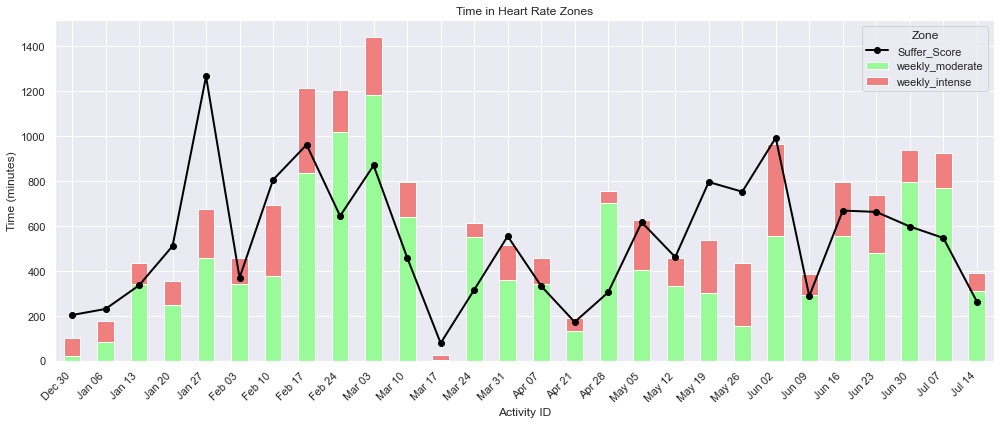

In [70]:
import matplotlib.pyplot as plt

ax = week_summary.plot(
    y=['weekly_moderate','weekly_intense'],
    x='week',
    kind='bar', 
    stacked=True, 
    figsize=(14, 6), 
    color=['#98FB98', '#F08080']
)

# Overlay line plot for 'weekly_suffer_score'
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="Suffer_Score"  
)

plt.title("Time in Heart Rate Zones");
plt.xlabel("Activity ID");
plt.ylabel("Time (minutes)");
plt.legend(title="Zone");
plt.xticks(rotation=45, ha='right');
plt.tight_layout();
plt.show();

### Drilling down a specific week

In [49]:
# default start is current week
start = week_summary.sort_values('week_start',ascending=False).iloc[0,0]
start = "2024-01-15" # <-- select custom week starting date

In [50]:
week_df, zone_week_df = display_detail_week(start, strava_df, strava_zone_df)
week_df[['id','name', 'date', 'sport', 'distance', 'time', 'speed', 'elev_gain',
       'avg_HR', 'max_HR', 'suffer_score']]
zone_week_df[['name','date','Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start',
       'weekly_intense']]

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score
4,10600329993,Tenerife D8 Churros and Leche-Leche,2024-01-21,Ride,28.9,2:34,11.3,2998.7,96.3,122.0,39.0
3,10595406083,Tenerife D7 Teide from the north,2024-01-20,Ride,61.1,5:29,11.1,8087.3,119.6,166.0,424.0
2,10588186702,Tenerife D6 Arico (but no loop due to stormy c...,2024-01-19,Ride,47.4,3:37,13.0,4248.0,105.0,146.0,103.0
1,10582706259,Tenerife D5 Masca,2024-01-18,Ride,53.3,5:08,10.4,7099.7,109.9,181.0,219.0
0,10576769362,"Tenerife D4 El Teide loop, Inside the Caldera",2024-01-17,Ride,75.3,6:15,12.0,8765.7,115.2,143.0,341.0
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,Ride,45.8,3:55,11.6,5394.4,110.3,134.0,165.0
8,10563366548,Tenerife D2 Arico Loop,2024-01-15,Ride,63.7,5:19,12.0,6026.2,107.2,139.0,172.0


,name,date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense
15,Tenerife D8 Churros and Leche-Leche,2024-01-21,55.5,98.5,0.3,0.0,0.0,154.0,0.3,2024-01-15,539.8
16,Tenerife D7 Teide from the north,2024-01-20,38.2,105.1,146.9,36.0,3.5,143.3,186.4,2024-01-15,539.6
17,Tenerife D6 Arico (but no loop due to stormy c...,2024-01-19,43.0,155.4,16.4,3.1,0.0,198.4,19.5,2024-01-15,353.2
18,Tenerife D5 Masca,2024-01-18,65.0,168.7,51.1,21.2,3.0,233.6,75.3,2024-01-15,333.7
19,"Tenerife D4 El Teide loop, Inside the Caldera",2024-01-17,32.6,194.2,135.2,13.5,0.0,226.8,148.7,2024-01-15,258.4
20,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,34.2,133.7,67.8,0.0,0.0,167.9,67.8,2024-01-15,109.7
21,Tenerife D2 Arico Loop,2024-01-15,49.0,228.6,41.5,0.4,0.0,277.6,41.9,2024-01-15,41.9


In [51]:
# Set number of rows to display
pd.set_option('display.max_rows', 20) #if set to None this will show all
pd.set_option('display.min_rows', 20)  # adjust to help override auto-truncation

strava_zone_df[['name','date','intense']]
pd.reset_option('display.max_rows')

,name,date,intense
0,Calpe D11 La Vall de Gallinera,2024-02-05,49.6
1,"Calpe afternoon walk,,,,,in the sun.",2024-02-04,21.5
2,Calpe D10 Castell de Castells loop,2024-02-04,93.1
3,Calpe D9 Val d’Ebo,2024-02-02,75.5
4,"Calpe D8 Pego, Olivia loop",2024-02-01,45.4
5,Calpe D7 ‘Serra D'Aiyana’ loop,2024-01-31,62.7
6,Calpe D6 Coll de Rate via Altea,2024-01-30,28.4
7,Calpe D5 La Musette,2024-01-29,26.2
8,Calpe D4 Puerto de Bernia Balcons loop,2024-01-28,11.3
9,Calpe Walk,2024-01-28,74.0


### Saving data

In [74]:
# verify before saving
strava_df.head(1)
strava_zone_df.head(1)
print(len(strava_df))
print(len(strava_zone_df))

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
3,15146585514,Sunshine to GoldHill return via Salina,2025-07-17,Ride,40.8,3:48,10.7,3794.9,115.5,153.0,186.0,228.6,4.8,2025-07-17 13:15:27+00:00


,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,15146585514,Sunshine to GoldHill return via Salina,2025-07-17,186.0,2025-07-17 13:15:27+00:00,4.5,159.3,64.0,0.8,0.0,163.8,64.8,2025-07-14,77.9,311.7,263.0


123
123


### Use save_data, and year

In [80]:
save_data(strava_df, strava_zone_df, 2025)

Data saved in folder: data/2025-07-17
